* 환경 : Windows 10 이상, python 3.9 ( 아마 python 3.7 이상이면 동작할 거에요. ) 
* PC에 엔비디아 그래픽카드가 없다면 Catboost 실행이 안될 거에요. 그땐, Catboost 파라미터 중 task_tpye='GPU'를 지워주시면 돼요.
* GPU를 사용하지 않으면, PC의 CPU 자원을 모두 활용하기 때문에, PC가 멈출 수 있어요(렉이 심해지거나).
* 그럴 때는 thread_count=(모델이 활용하길 바라는 CPU 개수) ex) thread_count=5 (기본값은 thread_count=-1 로, -1은 모두 사용이란 의미입니다.)


In [ ]:
# # 라이브러리 설치이니 아래 코드들을 주석을 지운 뒤 실행시켜 주시면 돼요. (기존에 설치되어 있는 패키지는 스킵하고 설치됩니다.)
# # 주석을 한번에 지우는 방법 ----> 지우고 싶은 줄들을 드래그 하고, ctrl + '/' 를 누르면 한번에 지워져요.

# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install imblearn
# !pip install matplotlib
# !pip install seaborn
# !pip install missingno
# !pip install catboost
# !pip install optuna

In [126]:
# Ignore Warning message
import warnings
warnings.filterwarnings('ignore')

# Random seed fix
import os
import random

# progress bar in repeated code
from tqdm import tqdm
import pandas as pd
import numpy as np

# Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Data Scaling
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Permutation Importance
import eli5
from eli5.sklearn import PermutationImportance

# Visualization
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import seaborn as sns
import missingno as msno

# Validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

# Scoring
from sklearn.metrics import f1_score

# Model & AutoML
import catboost
import optuna

In [111]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [112]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
subm = pd.read_csv('./sample_submission.csv')

In [113]:
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [114]:
train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')
train['LINE'] = train['LINE'].astype('category')

test['PRODUCT_CODE'] = test['PRODUCT_CODE'].astype('category')
test['LINE'] = test['LINE'].astype('category')

In [115]:
# train에서 열의 유일한 값이 nan이거나 모두 같은 값인 경우 해당 열을 제외
def remove_col(train_df, test_df):
    for x in train_df.columns[6:]:
        if train_df[x].nunique()==0 or (train_df[x].nunique()==1 and len(train_df[x].unique())==1): # nan 이거나 모두 같은 값인 경우
            train_df.drop(columns=[x], inplace=True)
            test_df.drop(columns=[x], inplace=True)
    return train_df, test_df

In [116]:
train, test = remove_col(train, test)

In [117]:
train.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Quality'], inplace=True)

test = test[train.columns[1:]]

In [118]:
train_x, train_y = train.drop(columns=['Y_Class']), train['Y_Class']

In [119]:
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN
1,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN
2,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,NaN
3,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,NaN
4,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,NaN


### catboost cv

In [120]:
train_y.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

* RepeatedStratifiedKFold를 활용하면 추후 test set의 결과를 추정할 수 있다.
* rskfold를 활용한 결과를 개선해나가는 것이 목표

In [15]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU') # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

15it [05:47, 23.17s/it]

0.5762430939226518 ~ 0.7513497039359108
mean : 0.6719199919417582


### Feature importance

* Permutation Importance를 사용하지 않은 이유는, train_x를 학습한 모델에서의 영향력을 보여주는 지표이기 때문
* train에서 영향력이 큰 컬럼일지라도, test에서 같은 컬럼이 value가 nan인 경우만 있을 수 있기 때문에 함부로 제거해서는 안된다.
* 따라서, Permutation Importance 에서 해당 컬럼이 영향력이 조금이라도 존재하는 경우 사용하기로 했다.

* Feature Importance는 학습된 모델에서 주로 사용된 컬럼들을 나타내기 때문에, 학습에 도움이 되지 않은 컬럼을 지워준다고 해도
* test predict에 영향력이 적다. 또한, 줄어든 컬럼으로 학습 방식이 바뀌고, overfit을 완화하여 더 나은 결과를 유도할 수 있다.

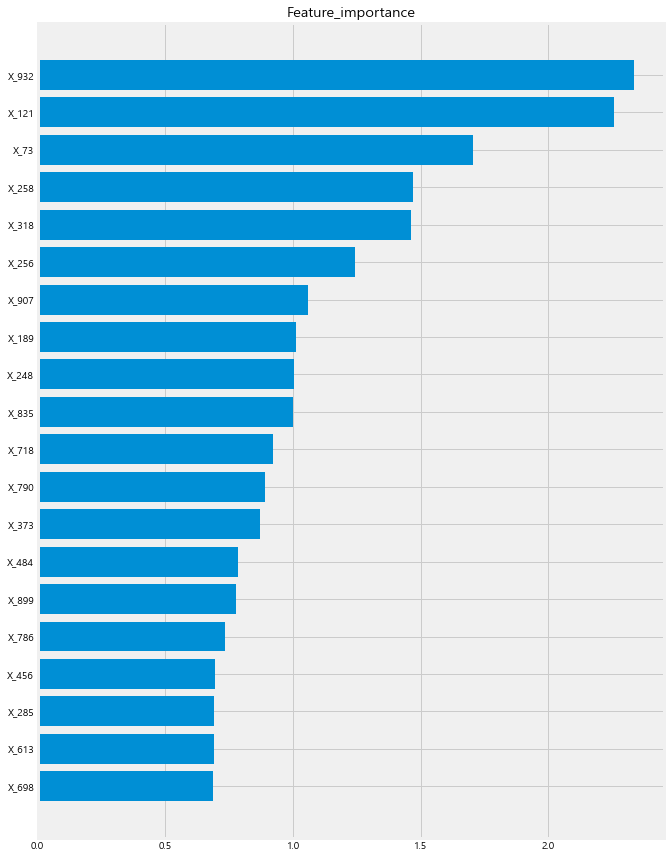

In [11]:
clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU')
clf.fit(train_x, train_y, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])

feat = clf.feature_importances_
feature_imp = pd.Series(feat, index=train_x.columns).sort_values(ascending=False)[:20].sort_values()

plt.rcParams["figure.figsize"] = (10, 15)
plt.barh(feature_imp.index, feature_imp)
plt.title('Feature_importance')
plt.show()

In [12]:
# # feature_importance > 0 인 컬럼만 선택
# tmp = pd.Series(feat[feat > 0], index=train_x.columns[feat > 0]).sort_values(ascending=False)[:]
# train_x = train_x[tmp.index]
# test = test[train_x.columns]
# train_x

,X_932,X_121,X_73,X_258,X_318,X_256,X_907,X_189,X_248,X_835,...,X_2068,X_1922,X_2865,X_2040,X_2412,X_931,X_1762,X_1930,X_564,X_981
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.23,NaN,NaN,...,0.000008,0.000000,353.0,0.000022,1.1,NaN,0.036773,0.000000,NaN,13.8
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN,NaN,...,0.000003,0.453569,353.0,0.000004,1.1,NaN,0.062509,0.036011,NaN,13.8
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.23,NaN,NaN,...,0.000009,0.000000,353.0,0.000021,1.1,NaN,0.030454,0.000000,NaN,13.8
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00,NaN,NaN,...,0.000002,0.000000,353.0,0.000003,1.1,NaN,0.064830,0.000000,NaN,13.7
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.23,NaN,NaN,...,0.000008,0.000000,352.0,0.000020,1.1,NaN,0.029483,0.000000,NaN,13.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,13.351613,34.1,10.09,NaN,NaN,NaN,17.276452,NaN,NaN,9.096774,...,NaN,NaN,NaN,NaN,NaN,13.6,NaN,NaN,15.0,NaN
594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.06,NaN,NaN,...,NaN,0.000000,353.0,NaN,1.1,NaN,0.019844,0.000000,NaN,13.8
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.06,NaN,NaN,...,NaN,0.000000,352.0,NaN,1.1,NaN,0.027558,0.000000,NaN,13.8
596,13.406667,33.7,10.22,NaN,NaN,NaN,17.277000,NaN,NaN,9.533333,...,NaN,NaN,NaN,NaN,NaN,13.6,NaN,NaN,15.0,NaN


In [129]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)

clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU') # cpu -> thread_count=5

perm_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])

    perm = PermutationImportance(clf).fit(x_val, y_val)
    perm_list.append(perm)

0it [00:00, ?it/s]Exception ignored in: <generator object tqdm.__iter__ at 0x000001ECF4E0D190>
Traceback (most recent call last):
  File "C:\Users\sajah\anaconda3\envs\py39\lib\site-packages\tqdm\std.py", line 1210, in __iter__
    self.close()
  File "C:\Users\sajah\anaconda3\envs\py39\lib\site-packages\tqdm\std.py", line 1304, in close
    fp_write('')
  File "C:\Users\sajah\anaconda3\envs\py39\lib\site-packages\tqdm\std.py", line 1301, in fp_write
    self.fp.write(_unicode(s))
  File "C:\Users\sajah\anaconda3\envs\py39\lib\site-packages\tqdm\utils.py", line 145, in inner
    return func(*args, **kwargs)
  File "C:\Users\sajah\anaconda3\envs\py39\lib\site-packages\ipykernel\iostream.py", line 531, in write
    self.pub_thread.schedule(lambda: self._buffer.write(string))
  File "C:\Users\sajah\anaconda3\envs\py39\lib\site-packages\ipykernel\iostream.py", line 216, in schedule
    self._event_pipe.send(b'')
  File "C:\Users\sajah\anaconda3\envs\py39\lib\site-packages\zmq\sugar\socket.

In [ ]:
eli5.show_weights(perm, feature_names = x_valid.columns.tolist(), top=20)

In [ ]:
perm_list = np.array(perm_list)
perm_mean = [np.mean(perm_list[:, i]) for i in perm_list]

train_x = train_x[train_x.columns[(feat > 0) & (perm_mean > 0)]]
test = test[train_x.columns]

train_x

In [18]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5, gpu -> task_type="GPU"
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

15it [03:33, 14.21s/it]

0.5957223001402524 ~ 0.7854452515469464
mean : 0.6866430811854247


### 결측치 대체

#### Missingno

<AxesSubplot:>

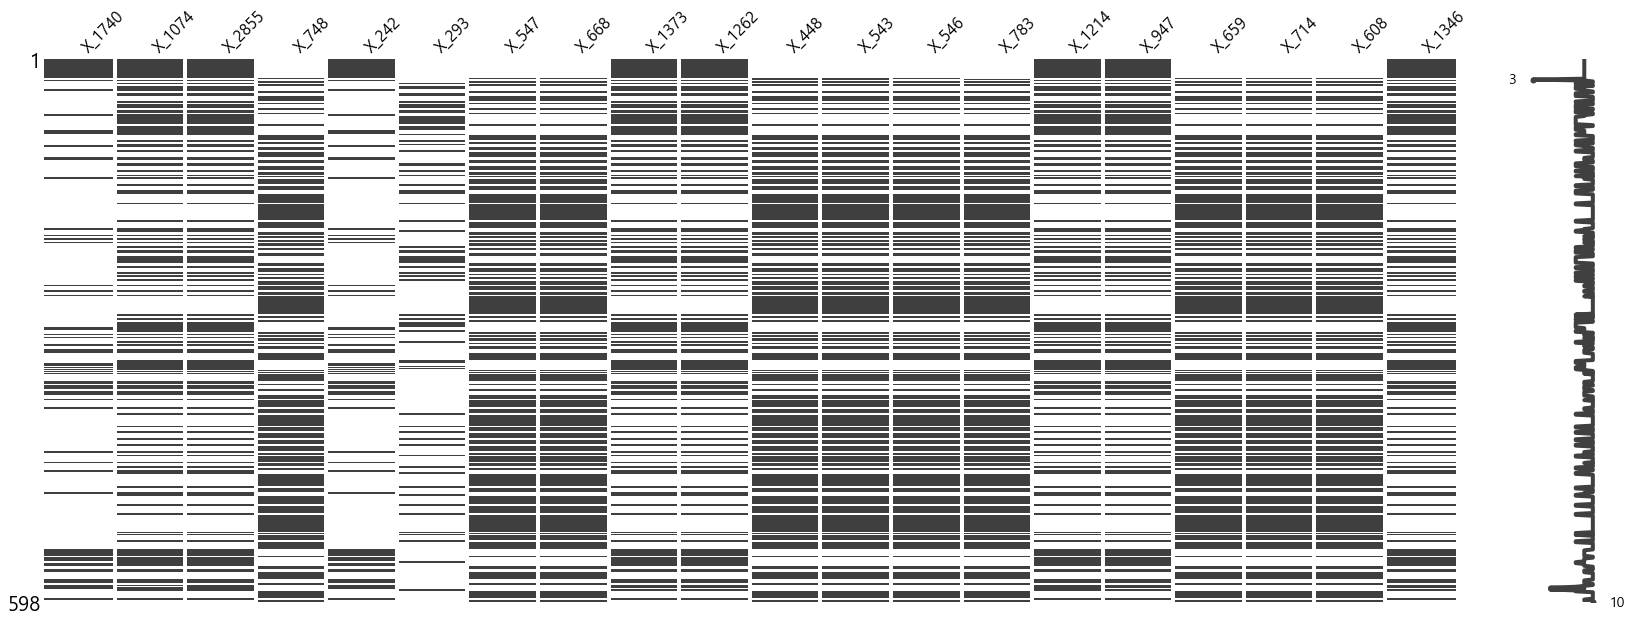

In [19]:
# 20개의 열만 뽑아 확인해 보았는데도 결측치가 굉장히 많다.
msno.matrix(train_x[train_x.columns[130:150]])

#### fillna(0)

* Catboost는 nan을 'string' 타입으로 치환하여 학습을 진행할 수 있다. 따라서 fillna(0)와 유사한 성능이 나타난다.
* MiceImputer, SimpleImputer 등 다양한 방법들을 활용해 보았지만, 성능향상에 도움이 되지 않았다.

In [13]:
train_x.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [94]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

15it [03:46, 15.12s/it]

0.5659667497076618 ~ 0.7441655356465552
mean : 0.6769210081447632


### Data Scaling

* 데이터의 적은 수를 극복하고자 오버샘플링을 통한 성능향상을 기대했지만 오히려 성능이 나빠졌다.
* 이는 컬럼 수가 너무 많고, 결측치를 0으로 바꾸었기 때문.
* 다른 컬럼과의 관계를 이용하지 않고, 단순히 데이터를 늘리는 랜덤오버샘플링도 성능이 향상되진 않았다.

In [22]:
def Randomoversampler(train_x_df, train_y_df):
    x_ros, y_ros = RandomOverSampler().fit_resample(train_x_df, train_y_df)
    return x_ros, y_ros

In [23]:
def SMOTE_Tomek(train_x_df, train_y_df):
    x_smoteenn, y_smoteenn = SMOTETomek().fit_resample(train_x_df, train_y_df)
    return x_smoteenn, y_smoteenn

In [24]:
def SMOTE_ENN(train_x_df, train_y_df):
    x_smoteenn, y_smoteenn = SMOTEENN().fit_resample(train_x_df, train_y_df)
    return x_smoteenn, y_smoteenn

In [25]:
def ADASYN_(train_x_df, train_y_df):
    x_adasyn, y_adasyn = ADASYN(sampling_strategy='minority').fit_resample(train_x_df, train_y_df)
    return x_adasyn, y_adasyn

In [26]:
def Borderline_SMOTE(train_x_df, train_y_df):
    x_b_smote, y_b_smote = BorderlineSMOTE().fit_resample(train_x_df, train_y_df)
    return x_b_smote, y_b_smote

#### RandomOverSampling

In [27]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = Randomoversampler(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

15it [04:00, 16.06s/it]

0.5352011494252874 ~ 0.7306722689075631
mean : 0.6521097147005214


* SMOTE ENN : 0.5908302192371786
* SMOTE Tomek : 0.641878141042391
* ADASYN : 0.6551906565507466
* Borderline SMOTE : 0.6455799000034791

### OPTUNA

#### OPTUNA

In [87]:
def cb_objective(trial):

    params = {
            'bootstrap_type':trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
            'od_wait':trial.suggest_int('od_wait', 500, 1000),
            'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.1),
            'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
            'random_strength': trial.suggest_uniform('random_strength',0,100),
            #'depth': trial.suggest_int('depth',2,15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,20),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
            'verbose': False,
            #"eval_metric": 'TotalF1',
            "one_hot_max_size": trial.suggest_int("one_hot_max_size", 1, 5),
            'task_type': 'GPU',
        }

#     if params['bootstrap_type'] == 'Bayesian':
#         params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
#     elif params['bootstrap_type'] == 'Bernoulli':
#         params['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    clf = catboost.CatBoostClassifier(**params)

    rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)

    f1_list = []
    for fold, (train_index, val_index) in enumerate(rskfold.split(train_x, train_y)):
        x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

        clf.fit(x_trn, y_trn, early_stopping_rounds=30)
        f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
    return np.mean(f1_list)

In [88]:
study = optuna.create_study(direction='maximize')
study.optimize(cb_objective, n_trials=20, show_progress_bar=True)

[I 2023-02-21 00:13:09,412] A new study created in memory with name: no-name-748cea92-2c85-4dfd-b754-2b969fb84307


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-02-21 00:14:48,419] Trial 0 finished with value: 0.6557833196093718 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 975, 'learning_rate': 0.06973855169227149, 'reg_lambda': 66.69835922895335, 'random_strength': 14.901388702644757, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 6, 'one_hot_max_size': 1}. Best is trial 0 with value: 0.6557833196093718.
[I 2023-02-21 00:16:29,150] Trial 1 finished with value: 0.6814900277771321 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 583, 'learning_rate': 0.04997268252509746, 'reg_lambda': 49.579821111612645, 'random_strength': 41.78291247647151, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 6, 'one_hot_max_size': 1}. Best is trial 1 with value: 0.6814900277771321.
[I 2023-02-21 00:18:05,921] Trial 2 finished with value: 0.6885480371387417 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 790, 'learning_rate': 0.0985164291554969, 'reg_lambda': 31.072697883916103, 'random_strength': 68.731703887157

In [89]:
# 결과값 비교
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [90]:
# 선택된 파라미터 조합 비교
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

In [91]:
# 가장 영향력이 큰 파라미터
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [92]:
print(study.best_trial.value, end='\n\n')
print(study.best_params)

0.7183237061487739

{'bootstrap_type': 'Bayesian', 'od_wait': 611, 'learning_rate': 0.08954166018036998, 'reg_lambda': 12.119124357119482, 'random_strength': 53.99747941125182, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 8, 'one_hot_max_size': 2}


In [93]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
clf = catboost.CatBoostClassifier(**study.best_params, verbose=0, task_type="GPU")

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

15it [05:24, 21.64s/it]

0.6091954022988505 ~ 0.7829192021636241
mean : 0.7045518820207224


#### threshold(임계값) 변경

In [40]:
def cb_objective(trial):

    params = {
            'bootstrap_type':trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
            'od_wait':trial.suggest_int('od_wait', 500, 1000),
            'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.1),
            'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
            'random_strength': trial.suggest_uniform('random_strength',0,100),
            #'depth': trial.suggest_int('depth',2,15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,20),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
            'verbose': False,
            #"eval_metric": 'TotalF1',
            "one_hot_max_size": trial.suggest_int("one_hot_max_size", 1, 5),
            'task_type': 'GPU',
        }
    
    clf = catboost.CatBoostClassifier(**params)

    rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)

    f1_list = []
    for fold, (train_index, val_index) in enumerate(rskfold.split(train_x, train_y)):
        x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
        clf.fit(x_trn, y_trn, early_stopping_rounds=30)
        
        # Y_Class = 1 이라고 예측했지만, 그 확률이 threshold 미만인 경우, 다른 Y_Class로 변경하도록 했다.
        pred = []
        for proba in clf.predict_proba(x_val):
            if list(proba).index(max(proba)) == 1 and max(proba) <= threshold:
                if proba[0] > proba[2]: 
                    pred.append(0)
                elif proba[0] < proba[2]:
                    pred.append(2)
                else:
                    pred.append(1)
            else:
                pred.append(list(proba).index(max(proba)))
                
        f1_list.append(f1_score(pred, y_val, average='macro'))
    
    return np.mean(f1_list)        

In [42]:
study_list = []
for th in [0.45, 0.475, 0.5, 0.525, 0.55, 0.575, 0.6]:
    threshold = th
    study2 = optuna.create_study(direction='maximize')
    study2.optimize(cb_objective, n_trials=20, show_progress_bar=True)
    study_list.append(study2)

[I 2023-02-20 23:23:44,396] A new study created in memory with name: no-name-cf778fef-4343-46aa-ac0b-c4b65f335c84


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-02-20 23:24:02,502] Trial 0 finished with value: 0.7353458721879775 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 848, 'learning_rate': 0.08034255016675118, 'reg_lambda': 93.80544015696368, 'random_strength': 72.76667361284203, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 3, 'one_hot_max_size': 4}. Best is trial 0 with value: 0.7353458721879775.
[I 2023-02-20 23:24:30,587] Trial 1 finished with value: 0.711369517778604 and parameters: {'bootstrap_type': 'Bernoulli', 'od_wait': 930, 'learning_rate': 0.09282932281353609, 'reg_lambda': 28.35888660081522, 'random_strength': 3.266627905658659, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 14, 'one_hot_max_size': 5}. Best is trial 0 with value: 0.7353458721879775.
[I 2023-02-20 23:24:48,877] Trial 2 finished with value: 0.6882868089764642 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 622, 'learning_rate': 0.06535607276025894, 'reg_lambda': 0.1644735382383352, 'random_strength': 53.77795458661389

[I 2023-02-20 23:31:00,345] A new study created in memory with name: no-name-2a0cd530-2021-4959-8d1c-8a190413d66c


[I 2023-02-20 23:31:00,343] Trial 19 finished with value: 0.6848385331143952 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 925, 'learning_rate': 0.02453246886176077, 'reg_lambda': 57.33920780739922, 'random_strength': 24.392807044232516, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 8, 'one_hot_max_size': 5}. Best is trial 0 with value: 0.7353458721879775.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-02-20 23:31:15,467] Trial 0 finished with value: 0.6249893896952721 and parameters: {'bootstrap_type': 'Bernoulli', 'od_wait': 705, 'learning_rate': 0.04403892846689716, 'reg_lambda': 96.53289359975707, 'random_strength': 48.071020436499055, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 1, 'one_hot_max_size': 1}. Best is trial 0 with value: 0.6249893896952721.
[I 2023-02-20 23:31:33,357] Trial 1 finished with value: 0.7198754488249275 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 732, 'learning_rate': 0.05732678280619778, 'reg_lambda': 13.364259216947003, 'random_strength': 19.557080227828482, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 4, 'one_hot_max_size': 1}. Best is trial 1 with value: 0.7198754488249275.
[I 2023-02-20 23:31:52,018] Trial 2 finished with value: 0.7462145969498911 and parameters: {'bootstrap_type': 'Bernoulli', 'od_wait': 587, 'learning_rate': 0.05763468055887792, 'reg_lambda': 34.68824254617613, 'random_strength': 54.8941517989

[I 2023-02-20 23:37:41,040] A new study created in memory with name: no-name-a9aaf4f8-3e62-4a2b-abf5-873a041ce788


[I 2023-02-20 23:37:41,038] Trial 19 finished with value: 0.7270760894440383 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 895, 'learning_rate': 0.08521538271283519, 'reg_lambda': 39.69171916312459, 'random_strength': 23.4979770958956, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 2, 'one_hot_max_size': 5}. Best is trial 2 with value: 0.7462145969498911.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-02-20 23:38:07,982] Trial 0 finished with value: 0.6761081295965017 and parameters: {'bootstrap_type': 'Bernoulli', 'od_wait': 976, 'learning_rate': 0.09135414722848871, 'reg_lambda': 50.796488615786366, 'random_strength': 73.19185773844954, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 13, 'one_hot_max_size': 1}. Best is trial 0 with value: 0.6761081295965017.
[I 2023-02-20 23:38:23,042] Trial 1 finished with value: 0.7146909315584015 and parameters: {'bootstrap_type': 'Bernoulli', 'od_wait': 897, 'learning_rate': 0.026240965478532413, 'reg_lambda': 31.138117645732002, 'random_strength': 47.00282554145655, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 1, 'one_hot_max_size': 3}. Best is trial 1 with value: 0.7146909315584015.
[I 2023-02-20 23:38:47,754] Trial 2 finished with value: 0.731748726655348 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 988, 'learning_rate': 0.03347894755539437, 'reg_lambda': 12.021480172570802, 'random_strength': 98.038189237

[I 2023-02-20 23:45:36,602] A new study created in memory with name: no-name-21bd1fad-de22-4807-9e9a-7d6eff1396e0


[I 2023-02-20 23:45:36,600] Trial 19 finished with value: 0.7270760894440383 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 928, 'learning_rate': 0.07329809925593823, 'reg_lambda': 36.43767332750203, 'random_strength': 13.97955227261751, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 13, 'one_hot_max_size': 4}. Best is trial 10 with value: 0.7392445076655604.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-02-20 23:46:01,394] Trial 0 finished with value: 0.7270760894440383 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 699, 'learning_rate': 0.038702445970359885, 'reg_lambda': 64.01777384518846, 'random_strength': 61.852853046494246, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 12, 'one_hot_max_size': 5}. Best is trial 0 with value: 0.7270760894440383.
[I 2023-02-20 23:46:27,274] Trial 1 finished with value: 0.7093315726592467 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 988, 'learning_rate': 0.02202203916666181, 'reg_lambda': 29.749558603815803, 'random_strength': 87.37517003554856, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 13, 'one_hot_max_size': 3}. Best is trial 0 with value: 0.7270760894440383.
[I 2023-02-20 23:46:52,959] Trial 2 finished with value: 0.7175267812593136 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 556, 'learning_rate': 0.023993548035654025, 'reg_lambda': 27.339619856872556, 'random_strength': 72.2173971

[I 2023-02-20 23:52:48,421] A new study created in memory with name: no-name-8441d7db-315a-4f8b-81f4-c5f9eee6899c


[I 2023-02-20 23:52:48,419] Trial 19 finished with value: 0.6864871882251756 and parameters: {'bootstrap_type': 'Bayesian', 'od_wait': 658, 'learning_rate': 0.09074491549650848, 'reg_lambda': 59.42575014521574, 'random_strength': 37.137493094381284, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 7, 'one_hot_max_size': 3}. Best is trial 6 with value: 0.7353458721879775.


  0%|          | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt



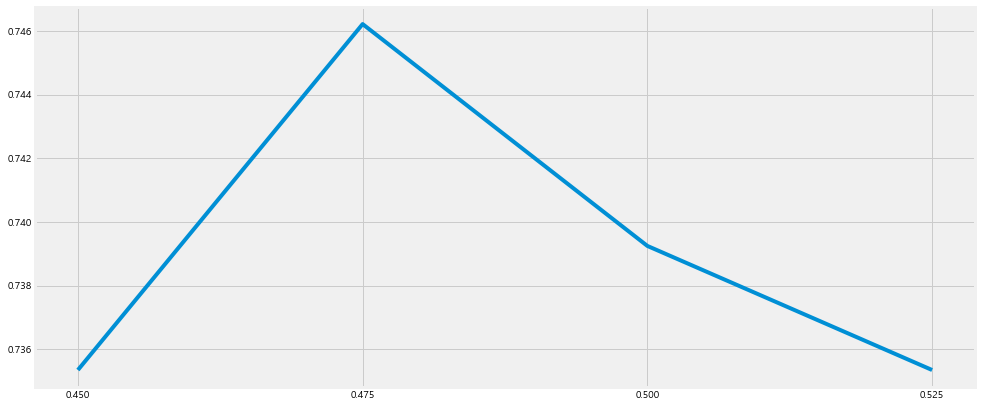

In [82]:
history = pd.Series([sdy.best_trial.value for sdy in study_list], index=[0.45, 0.475, 0.5, 0.525])

plt.rcParams["figure.figsize"] = (15, 7)
plt.plot(history)
plt.xticks([0.45, 0.475, 0.5, 0.525])
plt.show()

In [ ]:
clf = catboost.CatBoostClassifier(**study_list[history.index(max(history))].best_params, verbose=0).fit(train_x, train_y)

pred = []
for proba in clf.predict_proba(test):
    if list(proba).index(max(proba)) == 1 and max(proba) <= 0.475:
        if proba[0] > proba[2]: 
            pred.append(0)
        elif proba[0] < proba[2]:
            pred.append(2)
        else:
            pred.append(1)
    else:
        pred.append(list(proba).index(max(proba)))

#pred = clf.predict(test)
subm['Y_Class'] = pred

In [106]:
clf = catboost.CatBoostClassifier(task_type='GPU', verbose=0).fit(train_x, train_y)
pred = clf.predict(test)
subm['Y_Class'] = pred

In [107]:
subm.Y_Class.value_counts()

1    259
0     36
2     15
Name: Y_Class, dtype: int64

In [108]:
for a, b in zip(subm.Y_Class, pd.read_csv('./submission_36_feat_del.csv').Y_Class):
    if a != b:
        print(a, b)

2 0
1 0
1 2
1 2
2 1
2 1
2 1
0 1
2 1
2 0
2 1
2 1
2 0
2 1


In [102]:
clf = catboost.CatBoostClassifier(**study.best_params, verbose=0).fit(train_x, train_y)
pred = clf.predict(test)
subm['Y_Class'] = pred

In [103]:
subm.Y_Class.value_counts()

1    263
0     36
2     11
Name: Y_Class, dtype: int64

In [104]:
for a, b in zip(subm.Y_Class, pd.read_csv('./submission_36_feat_del.csv').Y_Class):
    if a != b:
        print(a, b)

0 1
1 0
1 0
0 1
1 2
2 1
2 1
1 0
1 0
2 1
2 1
2 1
0 1
1 0
1 0


In [ ]:
clf = catboost.CatBoostClassifier(**study_list[history.index(max(history))].best_params, verbose=0).fit(train_x, train_y)
pred = clf.predict(test)
subm['Y_Class'] = pred

In [55]:
subm.Y_Class.value_counts()

1    262
0     40
2      8
Name: Y_Class, dtype: int64

In [109]:
subm.to_csv('./submission_43_default.csv', index=False)

In [ ]:
### 기존, optuna, threshold 3개 제출